In [1]:
import os
import torch
import random
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
from models import build_model
from PIL import Image

#### Building the LaVIT Model and Load the checkpoint

In [2]:
# The local directory to save LaVIT checkpoint
model_path='/home/jinyang06/models/LaVIT_LLaMA2'
model_dtype='bf16'

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device_id = 0
torch.cuda.set_device(device_id)
device = torch.device('cuda')

# For Multi-modal Image Generation, must set `load_tokenizer=True` to load the tokenizer to tokenize input image.
# If you have already install xformers, set `use_xformers=True` to save the GPU memory (Xformers is not supported on V100 GPU)
# If you have already download the checkpoint, set `local_files_only=True`` to avoid auto-downloading from remote
model = build_model(model_path=model_path, model_dtype=model_dtype, check_safety=False,
            device_id=device_id, use_xformers=True, understanding=False, load_tokenizer=True)
model = model.to(device)    
print("Building Model Finsished")
torch_dtype = torch.bfloat16 if model_dtype=="bf16" else torch.float16


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading LaVIT Model Weight from /home/jinyang06/models/LaVIT_LLaMA2, model precision: bf16


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Use the Xformers for saving memory, please make sure your             device supports xformers. (V100 doesn't support now)
Load eva vitG weight from /home/jinyang06/models/LaVIT_LLaMA2/visual_tokenizer/eva_vitg_psz14.bin
Load visual tokenizer encoder weight from /home/jinyang06/models/LaVIT_LLaMA2/visual_tokenizer/tokenizer_encoder.bin
Load visual tokenizer decoder weight from /home/jinyang06/models/LaVIT_LLaMA2/visual_tokenizer/highres_tokenizer_decoder.bin
You are using XFormers ops, please make sure your device install and support xformers
Building Model Finsished


#### Image Synthesis with Multi-modal Prompts

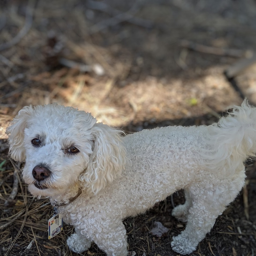

It is swimming in the river


100%|██████████| 50/50 [00:07<00:00,  6.79it/s]


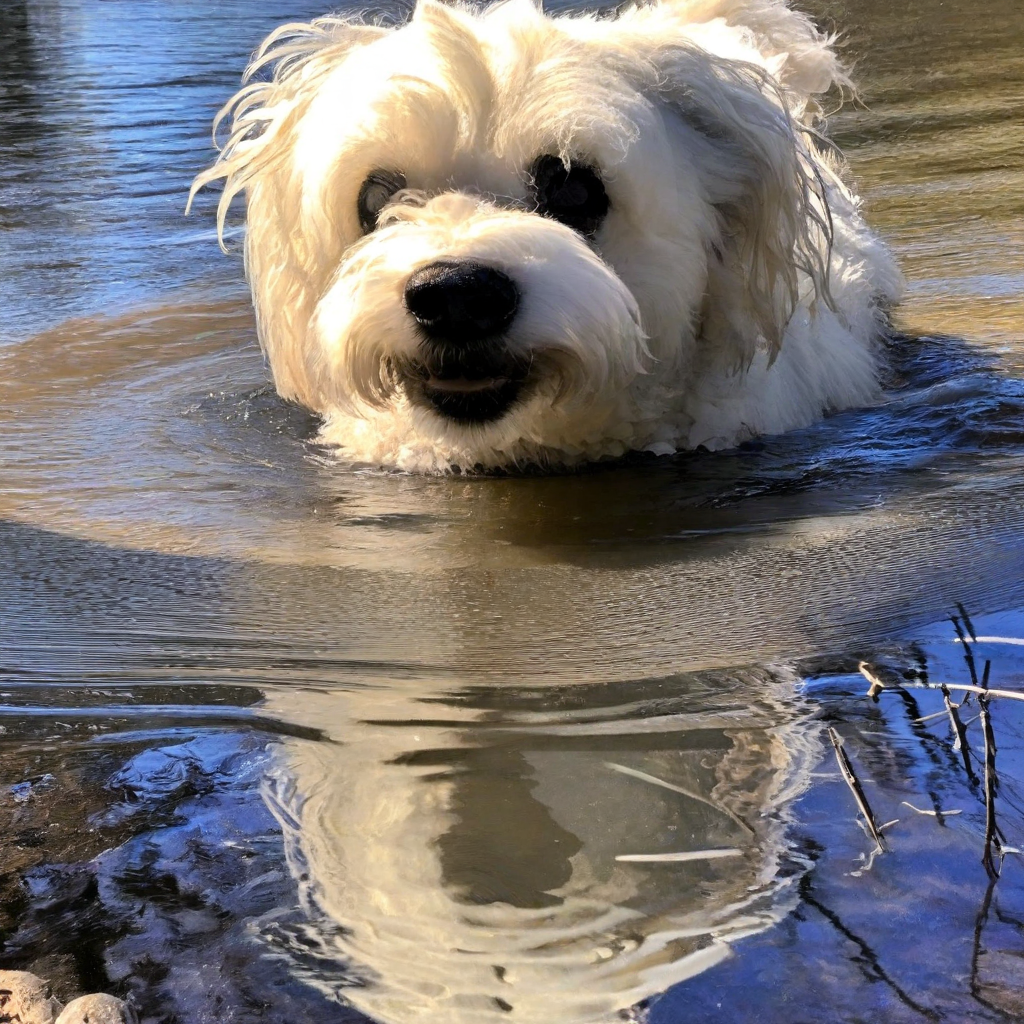

In [3]:
# Image + Text => Image
image_prompt = 'demo/dog.jpg'
text_prompt = 'It is swimming in the river'
# text_prompt = 'It is in the snow'
input_prompts = [(image_prompt, 'image'), (text_prompt, 'text')]

display(Image.open(image_prompt).resize((256, 256)))
print(text_prompt)

# LaVIT support 6 different image aspect ratios
ratio_dict = {
    '1:1' : (1024, 1024),
    '4:3' : (896, 1152),
    '3:2' : (832, 1216),
    '16:9' : (768, 1344),
    '2:3' : (1216, 832),
    '3:4' : (1152, 896),
}

# The image aspect ratio you want to generate
ratio = '1:1'
height, width = ratio_dict[ratio]

with torch.cuda.amp.autocast(enabled=True, dtype=torch_dtype):
    images = model.multimodal_synthesis(input_prompts, width=width, height=height,
        guidance_scale_for_llm=4.0, num_return_images=1, num_inference_steps=50, top_k=50)

display(images[0])
images[0].save('output/it2i_output.jpg')


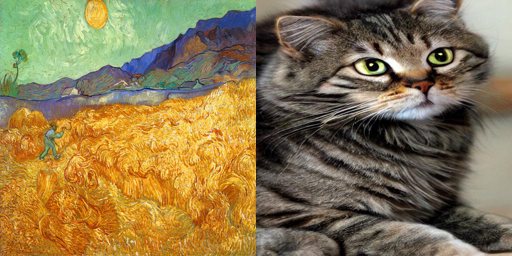

100%|██████████| 50/50 [00:07<00:00,  6.78it/s]


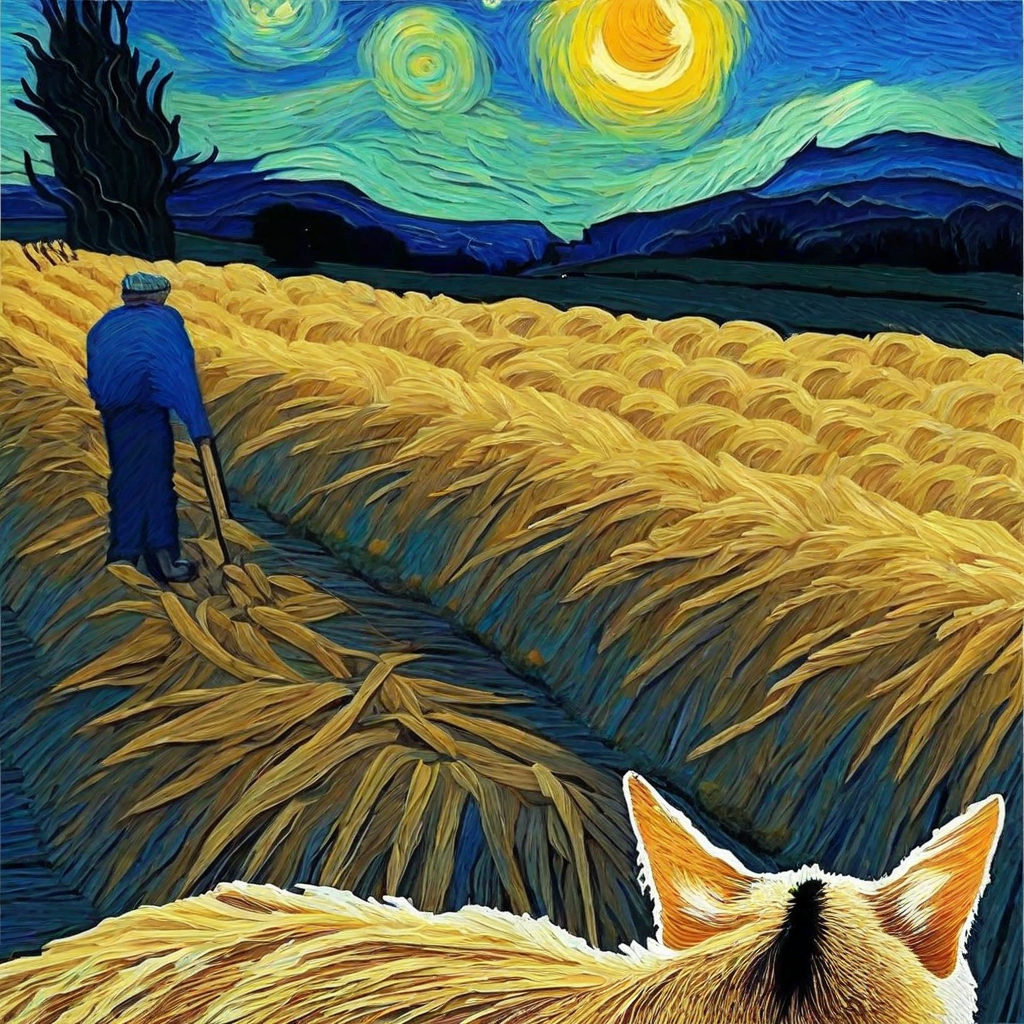

In [6]:
# Image + Image => Image
image1 = 'demo/image_input1.jpg'
image2 = 'demo/image_input2.jpg'
# image1 = 'demo/cyberpunk_dog.jpg'
# image2 = 'demo/image_input2.jpg'
input_prompts = [(image1, 'image'), (image2, 'image')]
display(image_grid([Image.open(image1).resize((256, 256)), Image.open(image2).resize((256, 256))], 1, 2))

# LaVIT support 6 different image aspect ratios
ratio_dict = {
    '1:1' : (1024, 1024),
    '4:3' : (896, 1152),
    '3:2' : (832, 1216),
    '16:9' : (768, 1344),
    '2:3' : (1216, 832),
    '3:4' : (1152, 896),
}

# The image aspect ratio you want to generate
ratio = '1:1'
height, width = ratio_dict[ratio]

with torch.cuda.amp.autocast(enabled=True, dtype=torch_dtype):
    images = model.multimodal_synthesis(input_prompts, width=width, height=height,
        guidance_scale_for_llm=8.0, num_return_images=1, num_inference_steps=50, top_k=50)


# display(images[0].resize((256, 256)))
# show_and_save(images, 2, 2)
display(images[0])
images[0].save('output/ii2i_output.jpg')